# InstaFriend
This project is about anlaysing and comparing two user activities on Instagram

##  1. Install & Import Relevant Packages

### Instagram API
https://github.com/facebookarchive/python-instagram

### Wordcloud
Visualize keywords of text string
https://github.com/amueller/word_cloud

### Mapbox
Inverse geocoding
https://www.mapbox.com/api-documentation/#endpoints

### Foliun
For web-based map visualization
https://github.com/python-visualization/folium

In [9]:
# import relevant packages
import instagram
from instagram.client import InstagramAPI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import urllib
import json
import time
import datetime
import re
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import mapbox
from mapbox import Geocoder
import folium
from collections import Counter
import re
import os
import mpl_toolkits.mplot3d.axes3d as p3
import colorsys
import time

## 2. Data Scrapping
- Authentication from users
- Data Scrapping from InstagramAPI
- Reconstructuring and Combining Data
- Saving Individual User Data

In [1]:
# get json data from InstagramAPI end points(url)

def get_data_json(url):
    # This function take a string as input and return a dictionary data
    
    # Input - the end point of InstagramAPI - string
    # Return - data from API - dictionary
    
    with urllib.request.urlopen(url) as u:
        data = json.loads(u.read().decode())
    return data

In [11]:
# get authentication & access token from users

def get_access_token(client_id, client_secret, redirect_uri, repeat):
    
    # This function takes 3 strings as input and 1 integer as input and return 2 lists
    # Input_1: client_id - string
    # Input_2: client_secret - string
    # Input_3: redirect_uri - string
    # Input_4: repeat times defaut 1 if not specified - integer
    
    # Return_1: access_token - string
    # Return_2: user_confidential - dictionary
    
    access_tokens = []
    user_confidentials = []
    
    api = InstagramAPI(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
        
    service_url = 'https://api.instagram.com/oauth/authorize/?client_id='+client_id+'&redirect_uri='+redirect_uri+'&response_type=code'
    
    for t in range(repeat):
        print('Get authentification from Friend_{}'.format(t+1))
        print('Please open the url and copy the new url from your browser')
        print(service_url)
        url_return = input('Enter the redirect url for: ')
        
        #Check if everything is alright
        try:
            url_return.split('code=')[1]
        except:
            print('Fail to get access token')
            print('Please check your client confidential and redirect url')
            print('You may restart')
            get_data_from_api()
        
        code = url_return.split('code=')[1]
        info_return = api.exchange_code_for_access_token(code)
        access_tokens.append(info_return[0])
        user_confidentials.append(info_return[1])
    
    return access_tokens, user_confidentials

In [3]:
# writ json file into computer
def write_json(file_name, data):
    # This function takes a string and a dictionary as input
    
    # Input_1: the file name you would like to create - string
    # Input_2: the dictionary to save - dictionary
    
    with open(file_name, 'w') as outfile:
        json.dump(data, outfile)
    return

In [4]:
# get all data availible 

def get_all_data(access_token, client_secret):
    
    # This function takes 1 list and 1 string as input and return a list
    
    # Input_1: access_token - list
    # Input_2: client_secret - string
    
    # return_1: information of n users - list
    # retrun_2: 20 most recent media of n users - list
    # return_3: comments of 20 most recent media of n users - list
    
    user_data = []
    media_data = []
    comment_data = []
    
    for t in range(len(access_token)):
        
        api = InstagramAPI(access_token=access_token[t], client_secret=client_secret)
        url_user_self = 'https://api.instagram.com/v1/users/self/?access_token=' + access_token[t]
        url_recent_media = 'https://api.instagram.com/v1/users/self/media/recent/?access_token=' + access_token[t]
        user_data.append(get_data_json(url_user_self))
        media_data.append(get_data_json(url_recent_media))
        media_id = [media_data[t]['data'][c]['id'] for c in range(len(media_data[t]['data']))]
        
        user_comment = []
        for n in range(len(media_id)):
            url_comment = 'https://api.instagram.com/v1/media/' + media_id[n] + '/comments?access_token=' + access_token[0]
            user_comment.append(get_data_json(url_comment))
        
        comment_data.append(user_comment)
        
    return user_data, media_data, comment_data

In [5]:
# Restructure and combine all data

def user_combine(user_data, media_data, comment_data):
    # This function takes three list as input and return a list
    
    # Input_1: the user information of n users - list
    # Input_2: the media of n users - list
    # Input_3: the comment of n users - list
    
    # Return: a list containing n users data - list
    
    users_all = []
    for n in range(len(user_data)):
        users_all.append({'info': user_data[n],
                          'media': media_data[n],
                          'comment': comment_data[n]})
    return users_all

In [6]:
# Scrap data from InstagramAPI and save the data to computer folder

def get_data_from_api(repeat=2):
    
    # This function take one option input that is default to 1 and return a string
    # Optional Input: the number of instagram user that you would like to extract the data
    # Return: the string of file name being saved
    
    client_id = '4c752d3964bb46138f4ad623ef9212bf'
    client_secret = 'c428cbf5335a4027ab3851f52c8d4d46'
    redirect_uri = 'https://www.hkbu.edu.hk/eng/main/index.jsp'
    
    print('Start authentication...')
    time.sleep(2)
    access_token, user_confidential = get_access_token(client_id, client_secret, redirect_uri, repeat=repeat)
    
    print('Authentication finished')
    time.sleep(2)
    
    print('Start scrapping user_data, media_data, and comment_data...')
    time.sleep(2)
    user_data, media_data, comment_data = get_all_data(access_token, client_secret)
    print('Finish scrapping data')
    
    time.sleep(2)
    print('Start saving data')
    time.sleep(2)
    user_file_name = []
    users_all = user_combine(user_data, media_data, comment_data)
    now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    for n in range(len(users_all)):
        user_id = users_all[n]['info']['data']['id']
        write_json('data/user_{}_{}.json'.format(user_id, now), users_all[n])
        user_file_name.append('data/user_{}_{}.json'.format(user_id, now))
    print('Data saved as:')
    print(user_file_name)
    
    return user_file_name

In [7]:
# Cheatsheet: this account is for you to test the above function
# user_testing (only for scrapping)
# user_name: mirrorpenguin
# user_password: cyltestingaccount

In [10]:
# customize input: repeat=2 as default, while here, for testing, we input repeat=1 since there is only one account
file_name_list = get_data_from_api(repeat=1)

Start authentication...
Get authentification from Friend_1
Please open the url and copy it from browser
https://api.instagram.com/oauth/authorize/?client_id=4c752d3964bb46138f4ad623ef9212bf&redirect_uri=https://www.hkbu.edu.hk/eng/main/index.jsp&response_type=code
Enter the redirect url for: https://www.hkbu.edu.hk/eng/main/index.jsp?code=a424ffeb012d4e0b97c3aeba5249af2a
Authentication finished
Start scrapping user_data, media_data, and comment_data...
Finish scrapping data
Start saving data
Data saved as:
['data/user_8217571_20181127184053.json']


# Data Cleaning
- Convert dictionary data into Panda DataFrame
- Drop unnecessary data
- Clean the format
    - 'created_time': the time the media was created ******
    - 'filter': the filter used in the media - string
    - 'id': the unique id of media - string
    - 'tags': the tag used in media - list
    - 'type': the type of media - string 'image' or 'video'
    - 'user_has_liked': if user likes his/her own photo - booleen
    - 'users_in_photo': other users in the photo - list
    - 'caption_text': the caption text written by user - string
    - 'comment_count': the number of comments of media - integer
    - 'image_url': the jpg link of media image - string
    - 'like_count': the number of likes of media - integer
    - 'latitude': the latitude of media location - string
    - 'longitude': the longitude of media location - string
    - 'place': the name of place of the media - string
    - 'user_id': the unique user id - string
    - 'comments': a list of comments for media - list

In [12]:
# open files containing users data

def load_user(file_name_list):
    # This function taks a list as input and return a list
    
    # Input: a list of file names - list
    # Return: a list of user dictionary dataset - list
    
    user_list = []
    for n in range(len(file_name_list)):
        with open(file_name_list[n], 'r') as json_file:
            user_list.append(json.load(json_file))
    return user_list

In [13]:
# Create a Dataframe for user basic profile

def get_user_profile(user_list):
    # This function takes a list as input and returns a dataframe
    
    # Input: a list of user dictionary dataset - list
    # Retrun: user profile - dataframe with columns
        # - 'id': the unique id of users - string
        # - 'username': unique username - string
        # - 'profile_picture': the jpg link of users' profile picture - string
        # - 'full_name': user's true full name - string
        # - 'bio': user's short introduction - string
        # - 'website': user's website - string
        # - 'media': the number of user's total media - integer
        # - 'follows': the number of user's following - integer
        # - 'followed_by': the number of user's followers - integer

    user_profile = pd.DataFrame(columns = ['id', 
                                           'username', 
                                           'profile_picture', 
                                           'full_name', 
                                           'bio',
                                           'website', 
                                           'media', 
                                           'follows', 
                                           'followed_by'])
    for col in user_profile.columns[0:6]:
        user_profile[col] = [user_list[n]['info']['data'][col] for n in range(len(user_list))]
    
    for col in user_profile.columns[6:]:
        user_profile[col] = [user_list[n]['info']['data']['counts'][col] for n in range(len(user_list))]
    
    return user_profile

In [14]:
# Get the dataframe of user's media

def get_media_df(user_dic):
    # This function takes a dictionary as input and return a dataframe
    
    # Input: a dictionary containing user's media info - dictionary
    # Return: a dataframe with columns
    
    media_df = pd.DataFrame(user_dic['media']['data'])
    
    try:
        media_df['caption_text'] = media_df.loc[media_df['caption'].notna()]['caption'].apply(lambda x: x.get('text'))
        media_df['comment_count'] = media_df['comments'].apply(lambda x: x.get('count'))
        media_df['image_url'] = media_df['images'].apply(lambda x: x.get('thumbnail').get('url'))
        media_df['like_count'] = media_df['likes'].apply(lambda x: x.get('count'))
        media_df['latitude'] = media_df.loc[media_df['location'].notna()]['location'].apply(lambda x: x.get('latitude'))
        media_df['longitude'] = media_df.loc[media_df['location'].notna()]['location'].apply(lambda x: x.get('longitude'))
        media_df['place'] = media_df.loc[media_df['location'].notna()]['location'].apply(lambda x: x.get('place'))
        media_df['user_id'] = media_df['user'].apply(lambda x: x.get('id'))

        media_df = media_df.drop(['attribution', 'link', 'user', 'comments', 'images', 'likes', 'caption', 'location'], axis=1)
    
        media_df['comments'] = pd.Series(user_dic['comment']).apply(lambda x: x.get('data'))
        media_df['created_time'] = pd.to_datetime(media_df['created_time'], unit='s')
    
    except KeyError:
        return media_df
    
    return media_df

In [15]:
# Combine all the data cleaning procedure

def data_clean(file_name_list):
    # This function takes a filename list as input and return a list and a datafram
    
    # Input: a list containing file names - list
    # Output_1: a dataframe of user basic profile - dataframe
    # Output_2: a list of dataframe containing user media information - list
    
    user_lists = load_user(file_name_list)
    user_profile = get_user_profile(user_lists)
    
    user_media_list = []
    for n in range(len(user_lists)):
        user_media_list.append(get_media_df(user_lists[n]))
        
    return user_profile, user_media_list

In [21]:
# cleaning data (using the prepared data)
# If you don't specify the test data name list (below), the dataset being used would be the previous one you scrapped
file_name_list = ['data/user_509161357_20181108124329.json', 'data/user_701341334_20181108125138.json']
user_pro, user_media_list = data_clean(file_name_list)

In [22]:
user_pro

,id,username,profile_picture,full_name,bio,website,media,follows,followed_by
0,509161357,queenabuttercookiepie,https://scontent.cdninstagram.com/vp/9e1b7071e...,QUEENA,"If it involves peanut butter, chocolate or adv...",,194,174,359
1,701341334,midoriillusion,https://scontent.cdninstagram.com/vp/22cc937e5...,Midori Who,Made on Earth by Humans.\nExpired Teenage Girl...,,267,412,507


In [23]:
# The first user
user_media_list[0].head(2)

,carousel_media,created_time,filter,id,tags,type,user_has_liked,users_in_photo,caption_text,comment_count,image_url,like_count,latitude,longitude,place,user_id,comments
0,NaN,2018-10-26 13:49:03,Normal,1898691978914516092_509161357,"[ilovebenandjerrys, whyusotasty]",image,False,[],Been on a no-sugar diet for 2 days and i'm pro...,0,https://scontent.cdninstagram.com/vp/02f449b3a...,49,NaN,NaN,NaN,509161357,[]
1,"[{'images': {'thumbnail': {'width': 150, 'heig...",2018-10-22 11:31:12,Normal,1895723489710914024_509161357,[],carousel,False,[],swipe right to see the way to my heart. First ...,5,https://scontent.cdninstagram.com/vp/7d4242548...,44,30.25,120.167,None,509161357,"[{'id': '17986428076070555', 'from': {'usernam..."


In [24]:
# The second User
user_media_list[1].head(2)

,carousel_media,created_time,filter,id,tags,type,user_has_liked,users_in_photo,caption_text,comment_count,image_url,like_count,latitude,longitude,place,user_id,comments
0,NaN,2018-11-07 08:30:08,Lark,1907228768546050143_701341334,[],image,False,"[{'user': {'username': 'jadehikari'}, 'positio...",A throwback to 2016 \nCr: @jadehikari,5,https://scontent.cdninstagram.com/vp/8efc3a18f...,41,NaN,NaN,NaN,701341334,"[{'id': '17961128518170693', 'from': {'usernam..."
1,"[{'images': {'thumbnail': {'width': 150, 'heig...",2018-11-01 08:25:47,Normal,1902877923129877676_701341334,[halloween2018],carousel,False,"[{'user': {'username': 'carriecheung28'}, 'pos...",#halloween2018 🎃\n“What are you dressing up as...,0,https://scontent.cdninstagram.com/vp/b9a218a4d...,54,22.280898,114.154768,None,701341334,[]


## 2. Users Profile Showing
- profile_pic
- username
- full_name
- bio
- website
- some statistics
    - followings
    - media number
    - caption keyword

In [25]:
# save & display user profile image

def save_profile_pic(user_pro, n):
    # This function takes a dataframe as input, saves and show users' profile image
    urllib.request.urlretrieve(user_pro['profile_picture'][n],'profile_pic/{}.jpg'.format(user_pro['full_name'][n]))
        
    profile_pic = Image.open('profile_pic/{}.jpg'.format(user_pro['full_name'][n]))
        
    plt.figure(figsize=(2,2))
    plt.imshow(profile_pic) 
    plt.axis("off")
    plt.show()
    
    return 

In [26]:
# Visualize user caption keyword in wordcloud

def caption_words(user_media_list, user_pro, n):
    # This function takes a list and a dataframe as input and will save some images

    # Input_one: user media list - list
    # Input_two: user profile - dataframe
    
    # Output_one: save users caption keywords to folder cloud_caption - .jpg
    text = ''
    text_original = user_media_list[n]['caption_text'][user_media_list[n]['caption_text'].notna()].values
    for t in text_original:
        t += ' '
        text += t
        
    text = re.sub('[^A-Za-z0-9]+',' ', text)
    text = text.lower()
        
    wordcloud = WordCloud(background_color="white").generate(text)
    cloud_image = plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    cloud_image.savefig('cloud_caption/{}_caption_keyword.jpg'.format(user_pro.iloc[n]['full_name']))
    
    return

In [27]:
def display_user_pro(user_pro, user_media_list):
    
    
    for n in range(len(user_media_list)):
        print('\nUser {} - {}'.format(n+1, user_pro.iloc[n]['full_name']))
        print('------------------------------------------------\n')
        save_profile_pic(user_pro, n)
        print('ID: {}'.format(user_pro.iloc[n]['id']))
        print('Account name: {}'.format(user_pro.iloc[n]['username']))
        print('Website: {}'.format(user_pro.iloc[n]['website']))
        print('Bio: {}'.format(user_pro.iloc[n]['bio']))
        print('Following: {}'.format(user_pro.iloc[n]['follows']))
        print('Total Post: {} '.format(user_pro.iloc[n]['media']))
        print('Post Keywords: ')
        caption_words(user_media_list, user_pro, n)
        
    return


User 1 - QUEENA
------------------------------------------------



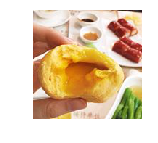

ID: 509161357
Account name: queenabuttercookiepie
Website: 
Bio: If it involves peanut butter, chocolate or adventures, I’m in
Following: 174
Total Post: 194 
Post Keywords: 


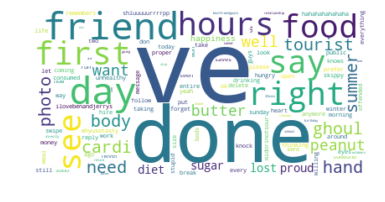


User 2 - Midori Who
------------------------------------------------



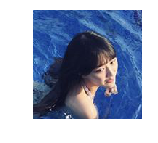

ID: 701341334
Account name: midoriillusion
Website: 
Bio: Made on Earth by Humans.
Expired Teenage Girl. Mfg: 02/1998
Following: 412
Total Post: 267 
Post Keywords: 


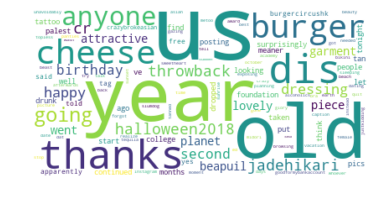

In [28]:
display_user_pro(user_pro, user_media_list)

## 3. Users Popularity Comparing
- some statistics
    - total follower
    - comment/post
    - like/post
    - comments_counts
    - like_counts


In [29]:
# Plot the like and comment number of two users
def like_comment_bar(user_pro, user_media_list):
    
    labels = ['like_count', 'comment_count']
    
    for label in labels:
        
        a1 = np.arange(len(user_media_list[0]))
        a2 = np.arange(len(user_media_list[1]))
        b1 = user_media_list[0][label].values
        b2 = user_media_list[1][label].values
        
        fig, ax = plt.subplots(1,1, figsize=(8,5))
        ax.barh(a1, -b1, facecolor='#9999ff', edgecolor='white', label='{}'.format(user_pro['full_name'][0]))
        ax.barh(a2, b2, facecolor='#ff9999', edgecolor='white', label='{}'.format(user_pro['full_name'][1]))
        
        for x, y in zip(a1, b1):
            if y != 0:
                ax.text(-y-0.07*max(b1), x-0.3, '%i'% y)
    
        for x, y in zip(a2, b2):
            if y != 0:
                ax.text(y, x-0.3, '%i'% y)
            
        plt.title('{} Comparison by Recent Media'.format(label), fontsize=15)
        plt.axis("off")
        plt.legend(bbox_to_anchor=(-0.1, 0.7), loc=1, borderaxespad=0.7, fontsize=13)
        plt.savefig('comparison/{}/{}&{}.jpg'.format(label, user_pro['id'][0], user_pro['id'][1]))
        plt.show()
        
    return

In [30]:
#  show the dataframe of user's popularity figures
def make_popularity_df(user_pro, user_media_list):
    
    ppl_df = pd.DataFrame(columns=[user_pro['full_name'][n] for n in range(len(user_pro))], 
                          index=['Follower', 'Like Per Post', 'Comment Per Post'])

    for n in range(len(user_pro)): 
        ppl_df[user_pro['full_name'][n]] = [user_pro['followed_by'][n], 
                                          user_media_list[n]['like_count'].sum()/len(user_media_list[n]), 
                                          user_media_list[n]['comment_count'].sum()/len(user_media_list[n])]
    
    print(ppl_df.astype(int))
    return 

In [31]:
def display_user_propularity(user_pro, user_media_list):
    
    print('\n')
    
    make_popularity_df(user_pro, user_media_list)
    print('\n')
    like_comment_bar(user_pro, user_media_list)
    
    return



                  QUEENA  Midori Who
Follower             359         507
Like Per Post         40          59
Comment Per Post       3           3




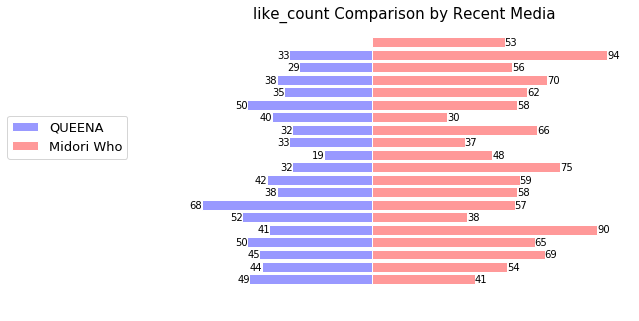

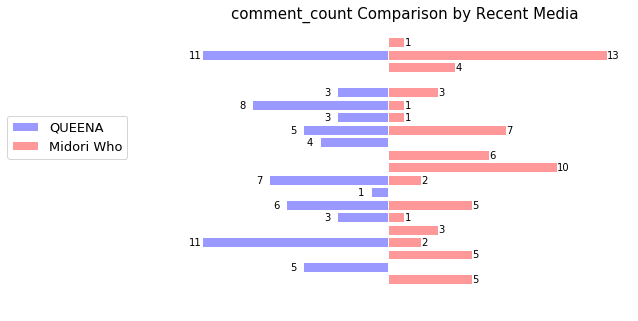

In [32]:
display_user_propularity(user_pro, user_media_list)

## 4. Things in Common
- visualize location
- Common tags and filters users like to use
    - show the filter effect
- user media frequent color comparison

In [33]:
# get the location information of a place
def reverse_geocoding(longitude, latitude, mapbox_access_token):
    # This function takes the a pair of coordinate, adn mapbox access token as inputs
    # it returns the dictionary data of information of a place
    url = 'https://api.mapbox.com/geocoding/v5/mapbox.places/{},{}.json?access_token={}'.format(longitude, latitude, mapbox_access_token)
    data = get_data_json(url)
    return data

In [34]:
def get_geo(user_pro, user_media_list, mapbox_access_token):
    #This function returns a list of users's location information
    geo_information = []
    
    for n in range(len(user_media_list)):
        geo_df = pd.DataFrame([user_media_list[n]['longitude'].dropna(), user_media_list[n]['latitude'].dropna()])
        geo_info = []
        for c in geo_df:
            geo_info.append(reverse_geocoding(geo_df[c]['longitude'], geo_df[c]['latitude'], mapbox_access_token))
        
        place_name, city_name, country_name = [], [], []
        for p in range(len(geo_info)):
            place_name.append(geo_info[p]['features'][0]['text'])
            city_name.append(geo_info[p]['features'][0]['context'][-2]['text'])
            country_name.append(geo_info[p]['features'][0]['context'][-1]['text'])
        location_df = pd.DataFrame({'longitude': user_media_list[n]['longitude'].dropna(),
                                    'latitude': user_media_list[n]['latitude'].dropna(),
                                    'place': place_name, 
                                    'city': city_name, 
                                    'country': country_name})
        
        geo_information.append(location_df)

    return geo_information

In [35]:
# Making maps
def make_map(geo_information, color_list):
    m = folium.Map(location=[30, 120], tiles="Mapbox Bright", zoom_start=14)
    for n in range(len(geo_information)):
        for i in range(len(geo_information[n])):
            folium.Marker(location = [geo_information[n].iloc[i]['latitude'], geo_information[n].iloc[i]['longitude']], 
                          icon=folium.Icon(color_list[n])).add_to(m)
    return m

In [36]:
# Ploting maps
def plot_loc_map(mapbox_access_token, user_pro, user_media_list):
    colors_list = ['green', 'blue', 'red']
    color_list = np.random.choice(colors_list, size=2, replace=False)
    geo_information = get_geo(user_pro, user_media_list, mapbox_access_token)
    m = make_map(geo_information, color_list)
    print('The User Location Map \n')
    for n in range(len(user_pro)):
        print(user_pro['full_name'][n]+': '+color_list[n])
    return m

In [37]:
mapbox_access_token = 'pk.eyJ1IjoiZWxsZW5jeWwiLCJhIjoiY2pvOG00NDRrMGJjczN0bjFvbHlxazN6MSJ9.LhRV8tHZ9HyWwSUDvZQ7iQ'

In [38]:
plot_loc_map(mapbox_access_token, user_pro, user_media_list)

The User Location Map 

QUEENA: green
Midori Who: red


In [39]:
# Plot the filter frequency tables for 2 users
def filter_frequency(user_media_list, user_pro):
    # This function plots the filter frequency charts of two users as well as return 
    
    filter_list = [user_media_list[n]['filter'].values for n in range(len(user_media_list))]
    filter_combine = list(set([fil for filter_sublist in filter_list for fil in filter_sublist]))
    y_pos = np.arange(len(filter_combine))
    
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    max_y = []
    
    for n in range(len(filter_list)):
        count = [list(filter_list[n]).count(fil) for fil in list(filter_combine)]
        ax.scatter(y_pos, count, label = user_pro['full_name'][n])
        max_y.append(max(count))

    ax.set_xticks(y_pos)
    ax.set_yticks(range(max(max_y)))
    ax.set_xticklabels(filter_combine)
    ax.set_ylabel('Count')
    ax.set_title('Filter Count of Different Users')
    plt.savefig('user_filter/filtr_usage')
    
    plt.legend()
    plt.show()
    return filter_list

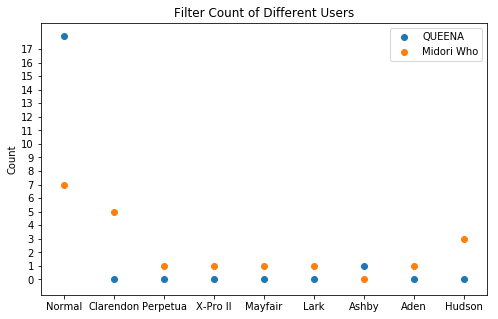

In [40]:
filter_list = filter_frequency(user_media_list, user_pro)

In [41]:
def get_filters(filter_list):
    #This function returns the filters used frequently (over 20% of time) by users
    filter_frequents = []
    for n in range(len(filter_list)):
        count = Counter(filter_list[n])
        filter_frequent = {}
        for label in count:
            if count[label] > 0.2*len(filter_list[n]):
                filter_frequent[label] = count[label]
        filter_frequents.append(filter_frequent)
    return filter_frequents

In [42]:
filter_frequents = get_filters(filter_list)

In [43]:
def display_top_filter(filter_frequents, user_pro):
    
    for n in range(len(filter_frequents)):
        print('The most frequent filter {} uses is {}'.format(user_pro['full_name'][n], [label for label in filter_frequents[n]]))
        print('\n')
        time.sleep(2)
        for f in filter_frequents[n]:
            print(f+':\n')
            print('Original Effect: ')
            original_image = Image.open('filters/Normal.png')
            plt.imshow(original_image) 
            plt.axis("off")
            plt.show()
            
            print('\n')
            print('With {} Effect: '.format(f))
            for filename in os.listdir('filters/'):
                if re.match('{}.+'.format(f), filename):
                    filter_image = Image.open('filters/{}'.format(filename))
                    plt.imshow(filter_image) 
                    plt.axis("off")
                    plt.show()
    return

The most frequent filter QUEENA uses is ['Normal']


Normal:

Original Effect: 


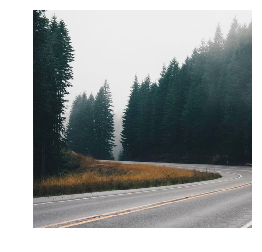



With Normal Effect: 


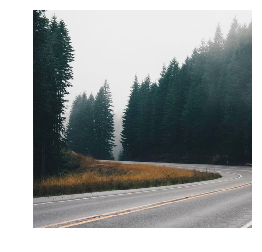

The most frequent filter Midori Who uses is ['Normal', 'Clarendon']


Normal:

Original Effect: 


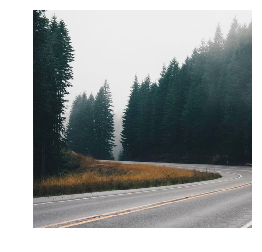



With Normal Effect: 


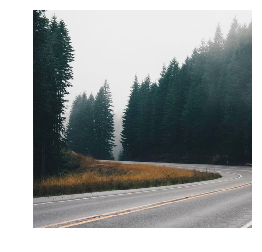

Clarendon:

Original Effect: 


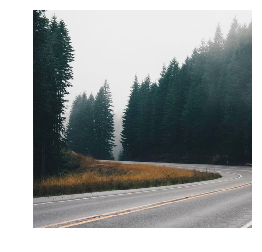



With Clarendon Effect: 


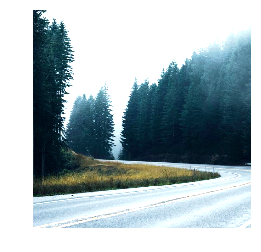

In [44]:
display_top_filter(filter_frequents, user_pro)

In [45]:
# save all the media photos of users
def save_media_photo(user_media_list):
    for n in range(len(user_media_list)):
        for media in user_media_list[n]['id']:
            url = user_media_list[n][user_media_list[n]['id'] == media]['image_url'].values[0]
            urllib.request.urlretrieve(url, 'media_photos/{}.jpg'.format(media))
    return 

In [46]:
def get_media_file_name(user_pro):
    # This function returns a list of user media file names
    
    media_file_names = [filename for filename in os.listdir('media_photos/')][1:]
    
    user_media_file_name = []
    
    for n in range(len(user_pro)):
        user_id = user_pro['id'][n]
        
        user_media = []
        for file in media_file_names:
            if user_id in file:
                user_media.append(file)
        
        user_media_file_name.append(user_media)
    return user_media_file_name

In [47]:
def get_hue_data(media_file_name):
    # This function is to get the hue features of each user medias
    
    hues = {}
    for name in media_file_name:
        img_file = Image.open('media_photos/{}'.format(name))
        img = img_file.load()

        [xs, ys] = img_file.size
        max_intensity = 1000
        
        for x in range(0, xs):
            for y in range(0, ys):
                [r, g, b] = img[x, y]
        
                r /= 255.0
                g /= 255.0
                b /= 255.0
        
                [h, s, v] = colorsys.rgb_to_hsv(r, g, b)
        
                if h not in hues: 
                    hues[h] = {}
                if v not in hues[h]:
                    hues[h][v] = 1
                else:
                    if hues[h][v] < max_intensity:
                        hues[h][v] += 1
    return hues

In [48]:
def make_frequent_color_plot(hues, user_pro):
    # This function is to plot the hue features
    for n, hue in enumerate(hues):
        
        h_ = []
        v_ = []
        i = []
        colours = []
        
        for h in hue:
            
            for v in hue[h]:
                h_.append(h)
                v_.append(v)
                i.append(hue[h][v])
                [r, g, b] = colorsys.hsv_to_rgb(h, 1, v)
                colours.append([r, g, b])
    
        fig = plt.figure()
        ax = p3.Axes3D(fig)
        ax.scatter(h_, v_, i, s=5, c=colours, lw=0)

        ax.set_xlabel('Hue Type')
        ax.set_ylabel('Intensity')
        ax.set_zlabel('Frequency')
        ax.set_title('Color Frequency For {}'.format(user_pro['full_name'][n]))
        fig.add_axes(ax)
        plt.savefig('comparison/color_usage/{}.jpg'.format(user_pro['full_name'][n]))
        plt.show()
    
    return

In [49]:
def display_media_color(user_pro):
    user_media_file_name = get_media_file_name(user_pro)
    hues = []
    for n in range(len(user_media_file_name)):
        hues.append(get_hue_data(user_media_file_name[n]))
    
    make_frequent_color_plot(hues, user_pro)
    return

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


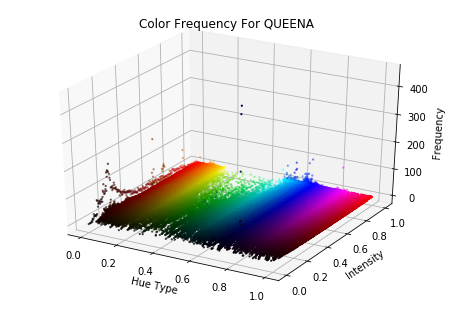

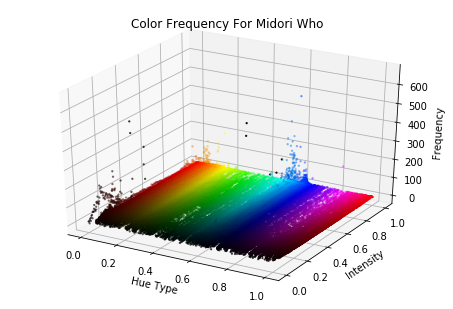

In [50]:
# This function takes some times
save_media_photo(user_media_list)
display_media_color(user_pro)

# Users Interaction Analysis
- How frequently you comment your friend's post
- How immediately you comment your friend's post
- How frequently you tag your friend

In [51]:
def reply_rate(user_pro, user_media_list):
    # This function is to get the user's friend's comment timestamp and calculate the replay rate
    
    usernames = [user_pro['username'][n] for n in range(len(user_media_list))]
    user_comment_time = []
    
    for n, username in enumerate(usernames):
        other_usernames = usernames.copy()
        other_usernames.remove(username)
        friends_comment_time = []
        for friend in other_usernames:
            friend_comment_time = {str(user_media_list[n]['created_time'][i]): None for i in range(len(user_media_list[n]['comments']))}
            for n_c, comments in enumerate(user_media_list[n]['comments']):
                if len(comments) != 0:
                    for comment in comments:
                        if comment['from']['username'] == friend:
                            if friend_comment_time[str(user_media_list[n]['created_time'][n_c])] is None:
                                friend_comment_time[str(user_media_list[n]['created_time'][n_c])] = comment['created_time']
            friends_comment_time.append(friend_comment_time)
        user_comment_time.append(friends_comment_time)
    return user_comment_time

In [52]:
def get_comment_time_df(user_pro, user_media_list):
    user_name = user_pro['username'][0]
    friend_name = user_pro['username'][1]
    
    user_order = int(user_pro[user_pro['username'] == user_name].index.values[0])
    friend_order = int(user_pro[user_pro['username'] == friend_name].index.values[0])
    
    comment_time = reply_rate(user_pro, user_media_list)
    user_time_df = pd.DataFrame(columns=['media_time','comment_time'])
    friend_time_df = pd.DataFrame(columns=['media_time','comment_time'])
    
    user_time_df['media_time'] = comment_time[user_order][0].keys()
    user_time_df['comment_time'] = comment_time[user_order][0].values()
    
    friend_time_df['media_time'] = comment_time[friend_order][0].keys()
    friend_time_df['comment_time'] = comment_time[friend_order][0].values()
    
    user_time_df['media_time'] = pd.to_datetime(user_time_df['media_time'])
    user_time_df['comment_time'] = pd.to_datetime(user_time_df['comment_time'], unit='s')
    user_time_df['Difference'] = user_time_df['comment_time'] - user_time_df['media_time']
    
    friend_time_df['media_time'] = pd.to_datetime(friend_time_df['media_time'])
    friend_time_df['comment_time'] = pd.to_datetime(friend_time_df['comment_time'], unit='s')
    friend_time_df['Difference'] = friend_time_df['comment_time'] - friend_time_df['media_time']
    
    return user_time_df, friend_time_df, user_name, friend_name

In [53]:
def respose_rate_and_time(time_df):
    
    if time_df['comment_time'].count() == 0:
        response_rate = 0
        response_time = 0
    else:
        response_rate = time_df['comment_time'].count()/time_df['media_time'].count()*100
        response_time = time_df['Difference'].mean()
    
    return response_rate, response_time

In [58]:
def cal_response(user_pro, user_media_list):
    
    user_time_df, friend_time_df, user_name, friend_name = get_comment_time_df(user_pro, user_media_list)
    response_rate_user, response_time_user = respose_rate_and_time(user_time_df)
    response_rate_friend, response_time_friend = respose_rate_and_time(friend_time_df)
    print('\n')
    print('Hi {} !'.format(user_name))
    if response_rate_user == 0:
        print('{} Never comment your post, are you guys really friend???'.format(friend_name))
        print('\n')
        time.sleep(2)
    else:
        print('{} comments {} % of your post.'.format(friend_name, round(response_rate_user)))
        print("You reply {}'s comments, on average, in {}".format(friend_name, response_time_user))
        print('\n')
        time.sleep(2)
        
    print('Hi {} !'.format(friend_name))
    if response_rate_friend == 0:
        print('{} Never comments your post, are you guys really friends???'.format(user_name))
        print('\n')
        time.sleep(2)
    else:
        print('{} comments {} % of your post.'.format(user_name, round(response_rate_friend)))
        print("You reply {}'s comments, on average, in ".format(user_name, response_time_friend))
        print('\n')
    
    return

In [59]:
cal_response(user_pro, user_media_list)



Hi queenabuttercookiepie !
midoriillusion comments 32.0 % of your post.
You reply midoriillusion's comments, on average, in 0 days 04:51:53.833333


Hi midoriillusion !
queenabuttercookiepie Never comments your post, are you guys really friends???




# Run The Program

In [60]:
def instafriend(testing=True):
    
    # Get Authentication
    print('Hello, welcome to InstaFriend:)')
    time.sleep(2)
    
    # Get file name list if testing
    if testing == True:
        print('You are testing the program, we will use prepared dataset')
        time.sleep(2)
        file_name_list = ['data/user_509161357_20181108124329.json', 'data/user_701341334_20181108125138.json']
    
    # Get authentication if not testing
    else:
        print('First, lets start authentication')
        time.sleep(2)
        file_name_list = get_data_from_api()
        time.sleep(2)
        print('Congratulation! Authentication Success!\n')
    
    #Clean dataset
    user_pro, user_media_list = data_clean(file_name_list)
    
    # Display User Profile
    print('Here is the profile information of you and your friend !')
    time.sleep(2)
    display_user_pro(user_pro, user_media_list)
    
    # Display user popularity
    print('\n Lets compare the popularity of you and your friend !')
    time.sleep(2)
    display_user_propularity(user_pro, user_media_list)
    
    # Geographical location 
    mapbox_access_token = 'pk.eyJ1IjoiZWxsZW5jeWwiLCJhIjoiY2pvOG00NDRrMGJjczN0bjFvbHlxazN6MSJ9.LhRV8tHZ9HyWwSUDvZQ7iQ'
    print('\n Check our here where you and your friend have been !')
    time.sleep(2)
    plot_loc_map(mapbox_access_token, user_pro, user_media_list)
    print('\n')
    
    # Filter usage habits
    print('Check out here the filter usage of you and your friend')
    filter_list = filter_frequency(user_media_list, user_pro)
    filter_frequents = get_filters(filter_list)
    display_top_filter(filter_frequents, user_pro)
    print('\n')
    
    # Media color analysis
    print('Check out the color frequency chart in you and your friends posts')
    time.sleep(2)
    save_media_photo(user_media_list)
    display_media_color(user_pro)
    print('\n')
    
    # User interaction analysis
    print('Check out here how you and your friend interact\n')
    time.sleep(2)
    cal_response(user_pro, user_media_list)
    
    print('This is the end of the program, with you good luck in your friendship!')
    
    return

Hello, welcome to InstaFriend:)
You are testing the program, we will use prepared dataset
Here is the profile information of you and your friend !

User 1 - QUEENA
------------------------------------------------



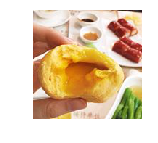

ID: 509161357
Account name: queenabuttercookiepie
Website: 
Bio: If it involves peanut butter, chocolate or adventures, I’m in
Following: 174
Total Post: 194 
Post Keywords: 


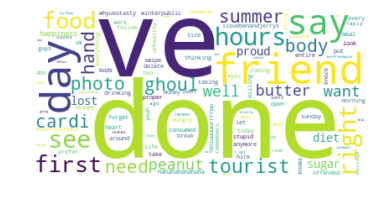


User 2 - Midori Who
------------------------------------------------



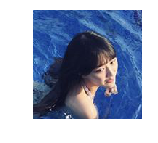

ID: 701341334
Account name: midoriillusion
Website: 
Bio: Made on Earth by Humans.
Expired Teenage Girl. Mfg: 02/1998
Following: 412
Total Post: 267 
Post Keywords: 


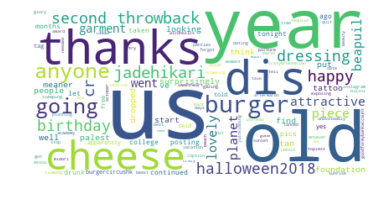


 Lets compare the popularity of you and your friend !


                  QUEENA  Midori Who
Follower             359         507
Like Per Post         40          59
Comment Per Post       3           3




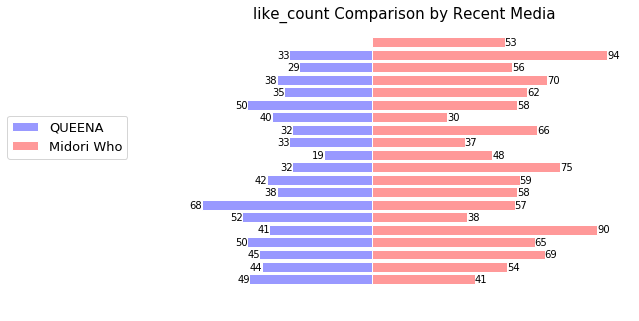

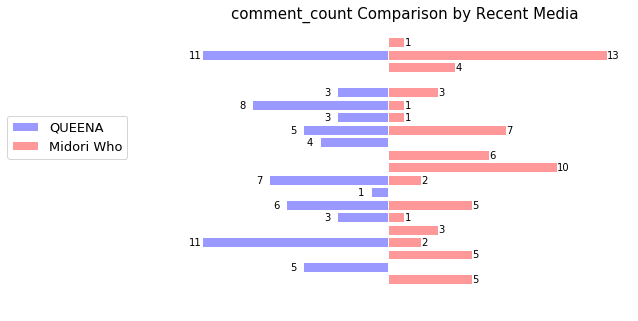


 Check our here where you and your friend have been !
The User Location Map 

QUEENA: red
Midori Who: blue


Check out here the filter usage of you and your friend


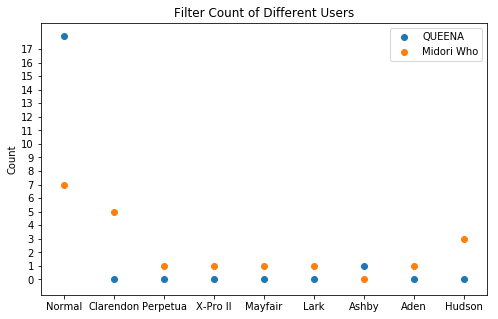

The most frequent filter QUEENA uses is ['Normal']


Normal:

Original Effect: 


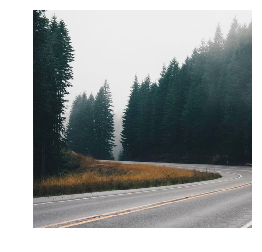



With Normal Effect: 


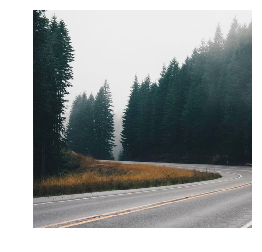

The most frequent filter Midori Who uses is ['Normal', 'Clarendon']


Normal:

Original Effect: 


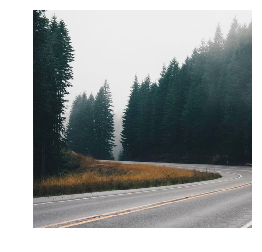



With Normal Effect: 


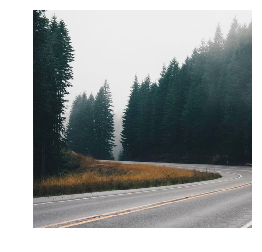

Clarendon:

Original Effect: 


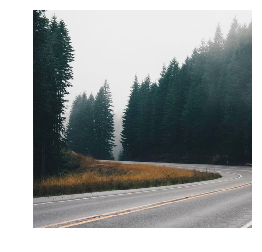



With Clarendon Effect: 


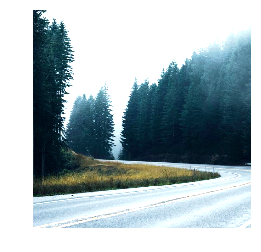



Check out the color frequency chart in you and your friends posts


/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


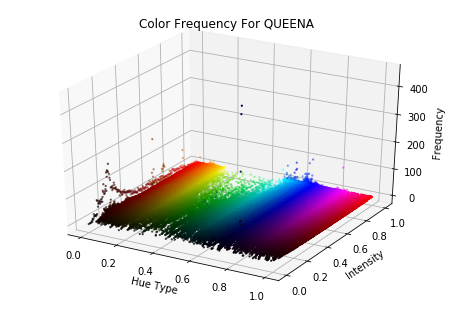

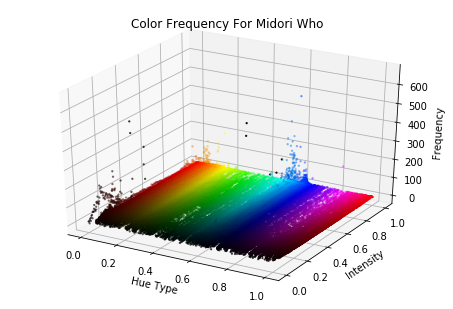



Check out here how you and your friend interact



Hi queenabuttercookiepie !
midoriillusion comments 32.0 % of your post.
You reply midoriillusion's comments, on average, in 0 days 04:51:53.833333


Hi midoriillusion !
queenabuttercookiepie Never comments your post, are you guys really friends???


This is the end of the program, with you good luck in your friendship!


In [61]:
# run the whole program (there is some issue with presenting map in this way since it is usally being display in web)
instafriend()